# Computing Spec2Vec similarity score for several space dimensions 20 times

To test the performance of spec2vec in the following dimensionalities were used: 2, 50, 100, 300, 500, 600, 650, 700, 750, 800, 100 and 1200. Each one of them was computed 20 times for percentiles 1st and 0.07th

## Obtaining the data from the Mona File

## Getting the path for Mona file

Using the method load_from_msp, the information inside the Mona file is being obtained.

In [1]:
import os
import sys

ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)

In [2]:
from custom_functions.spectra_functions import get_data_folder_path

path = get_data_folder_path()
path

'/Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data'

## Load Tanimoto similarity matrix

In [12]:
import numpy as np

filename = os.path.join(path, "gcms_similarities_filter05_morgan3_2048_dice.npy")
matrix_similarities_tanimoto = np.load(filename)

print("Matrix dimension", matrix_similarities_tanimoto.shape)

Matrix dimension (14844, 14844)


## Function to compute average molecular molecular similarity at a specific percentile

In [14]:
import re
import unidecode
from matplotlib import pyplot as plt

def get_precentile_avg_mol_sim(arr_ref, arr_sim, percentile_rn, ignore_diagonal=False):
    ## Code inspired by Florian Huber's jupyter notebook to compute top percentile average similarity score
    ## https://github.com/iomega/spec2vec_gnps_data_analysis/blob/master/custom_functions/plotting_functions.py
    
    # function to search and obtain nan elemnts and delete them
    # First checks if the arrays has the same length
    # Then obtaines the indexes of the elements that are not nan of the reference array
    # Then overwrites both arrays without the position on which were nans in the reference array
    def _ignore_reference_nans(arr_ref, arr_sim):
        assert arr_ref.shape == arr_sim.shape, "Expected two arrays of identical shape."
        idx_not_nans = np.where(np.isnan(arr_ref) == False)
        arr_sim = arr_sim[idx_not_nans]
        arr_ref = arr_ref[idx_not_nans]
        return arr_ref, arr_sim

    # If true replace the elements in the diagonal with NaN
    if ignore_diagonal:
        np.fill_diagonal(arr_ref, np.nan)

    # Call to this method to remove the NaN elements from the arrays
    arr_ref, arr_sim = _ignore_reference_nans(arr_ref, arr_sim)

    # Obtain the index position according to the percentile
    start = int(arr_sim.shape[0] * percentile_rn / 100)
    idx = np.argpartition(arr_sim, -start)
    starting_point = arr_sim[idx[-start]]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")

    # Obtain only the elements on the given percentile
    low_as = np.where(arr_sim < starting_point)[0]

    # Set the length of the array to the length of the new list with the percentile elements
    length_selected = arr_sim.shape[0] - low_as.shape[0]  # start+1

    # Create a new array of zeros where the elements of array_ref and array_sim will be added
    data = np.zeros((2, length_selected))
    # Add arr_sim values to first position and arr_ref to second position
    data[0, :] = np.delete(arr_sim, low_as)
    data[1, :] = np.delete(arr_ref, low_as)

    # Order the data according to arr_sim scores
    data = data[:, np.lexsort((data[1, :], data[0, :]))]

    # Return mean molecular similarity score of arr_ref 
    # return np.mean(data[1, :])
    return np.mean(data[1])

## Loading Mona file spectra

In [3]:
from matchms.importing import load_from_msp

msp_file = os.path.join(path, "MoNA-export-GC-MS.msp")
spectrums = [s for s in load_from_msp(msp_file)]
print("Number of Spectra:", len(spectrums))

Number of Spectra: 14847


## Appliying filters to the spectra

Applied filters are:
* normalize_intensities(s)
* select_by_mz(s, mz_from=0, mz_to=1000)
* select_by_relative_intensity(s, intensity_from=0.05, intensity_to=1.0)

In [4]:
from matchms.filtering import normalize_intensities
from matchms.filtering import select_by_mz
from matchms.filtering import select_by_relative_intensity

def apply_my_filters(s):
    s = normalize_intensities(s)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = select_by_relative_intensity(s, intensity_from=0.01, intensity_to=1.0)
    return s

spectrums = [apply_my_filters(s) for s in spectrums]

spectrums = [s for s in spectrums if s is not None]

#Filter spectra with peak intensities length equals or less than zero
spectrums = [s for s in spectrums if len(s.peaks.intensities) > 0]

print("Number of Spectra:", len(spectrums))

Number of Spectra: 14844


## Converting Spectrum objects to Spectrum Documents

In [5]:
from spec2vec import SpectrumDocument

reference_documents = [SpectrumDocument(s) for s in spectrums]

query_documents = reference_documents.copy()

## Training the word2vec model 20 times for each space dimension

Data used for training the model:\
**Iterarions=10, 20, 30**\
**Workers=2**

The code computes train, load word2vec and computes similarity score for the aforementioned space dimensions 20 times.
Once the similarity matrix is computed the scores are stored for further use in the score calculation

## Computing 0.7th percentile after obtaining Spec2Vec scores

In [24]:
import gensim
from datetime import datetime
from matchms import calculate_scores_parallel
from spec2vec import Spec2VecParallel
from spec2vec.model_building import train_new_word2vec_model


dimensions = [2, 50, 100, 300, 500, 600, 650, 700, 750, 800, 1000, 1200]
percentile = 0.007
iterations_length = len(dimensions) * 20
iterations_list = []
count = 0

def get_time():
    now = datetime.now()
    current_time = now.strftime("%H:%M:%S")
    current_time = "Time = " + current_time
    return current_time

print("Started at: " + str(get_time()))

for idx in range(20):
    print("Iteration " + str(idx+1))
    percentile_cosine_spec2vec = []
    
    for dimension in dimensions:
        
        model_name = "references-2-it{:d}-d{:d}.model".format(idx+1, dimension)
        model_file = os.path.join(path, model_name)
        model = train_new_word2vec_model(documents=reference_documents, filename=model_file, 
                                         size=dimension, iterations=[10, 20, 30],
                                         workers=2, progress_logger=False)

        model = gensim.models.Word2Vec.load(model_file)

        # Define similarity_function
        spec2vec = Spec2VecParallel(model=model, intensity_weighting_power=0.5,
                                    allowed_missing_percentage=5.0)

        matrix_similarities_spec2vec = spec2vec(reference_documents, query_documents)
        
        filename = os.path.join(path, 'similarities_filter05_spec2vec_2_it' + str(idx+1) + '_size' + str(dimension) + '.npy')
        np.save(filename, matrix_similarities_spec2vec)
        
        percentile_cosine_spec2vec.append(get_precentile_avg_mol_sim(matrix_similarities_tanimoto, matrix_similarities_spec2vec, percentile, ignore_diagonal=True))
        
        count += 1
        print("\r", "About {:.3f}% completed".format(100 * count/iterations_length), get_time(), end="\n")
    iterations_list.append(percentile_cosine_spec2vec)
    
filename = os.path.join(path,'avg_mol_sim_spec2vec_20iterarions_percentile07.npy')
np.save(filename, iteratoins_list)
print("Finished at: " + str(get_time()))

Started at: Time = 09:15:50
Iteration 19
The value of size is set from 300 (default) to 2
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it19-d2_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it19-d2_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it19-d2.model
 About 0.417% completed Time = 09:17:16
The value of size is set from 300 (default) to 50
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it19-d50_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it19-d50_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysi

Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it20-d300.model
 About 6.667% completed Time = 10:40:06
The value of size is set from 300 (default) to 500
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it20-d500_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it20-d500_iter_20.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it20-d500.model
 About 7.083% completed Time = 10:45:57
The value of size is set from 300 (default) to 600
The value of workers is set from 4 (default) to 2
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analysis/data/references-2-it20-d600_iter_10.model
Saving model with name: /Users/efra/../../Volumes/easystore/spec2vec_gcms_data_analy

## Computing 1st percentile after obtaining Spec2Vec scores

In [103]:
iterations_list = []
percentile = 0.01
iterations_length = len(dimensions) * 20
count = 0

print("Started at: " + str(get_time()))

for idx in range(20):
    print("Iteration " + str(idx+1))
    percentile_cosine_spec2vec = []
    
    for dimension in dimensions:
        
        filename = os.path.join(path, 'similarities_filter05_spec2vec_2_it' + str(idx+1) + '_size' + str(dimension) + '.npy')
        similarity_matrix_spec2vec = np.load(filename)
        percentile_cosine_spec2vec.append(get_precentile_avg_mol_sim(matrix_similarities_tanimoto, similarity_matrix_spec2vec, percentile, ignore_diagonal=True))
        count += 1
        print("\r", "About {:.3f}% completed\n".format(100 * count/iterations_length), get_time(), end="")
    iterations_list.append(percentile_cosine_spec2vec)
    
filename = os.path.join(path,'avg_mol_sim_spec2vec_20iterarions_percentile1.npy')
np.save(filename, iteratoins_list)
print("Finished at: " + str(get_time()))

Started at: Time = 17:07:02
Iteration 1
 About 0.417% completed
 About 0.833% completed
 About 1.250% completed
 About 1.667% completed
 About 2.083% completed
 About 2.500% completed
 About 2.917% completed
 About 3.333% completed
 About 3.750% completed
 About 4.167% completed
 About 4.583% completed
 About 5.000% completed
 Time = 17:16:56Iteration 2
 About 5.417% completed
 About 5.833% completed
 About 6.250% completed
 About 6.667% completed
 About 7.083% completed
 About 7.500% completed
 About 7.917% completed
 About 8.333% completed
 About 8.750% completed
 About 9.167% completed
 About 9.583% completed
 About 10.000% completed
 Time = 17:25:59Iteration 3
 About 10.417% completed
 About 10.833% completed
 About 11.250% completed
 About 11.667% completed
 About 12.083% completed
 About 12.500% completed
 About 12.917% completed
 About 13.333% completed
 About 13.750% completed
 About 14.167% completed
 About 14.583% completed
 About 15.000% completed
 Time = 17:34:18Iteration 4

## Plotting average molecilar similarity of 0.7th percentile of all space dimensions
## Plotting average molecilar similarity of 0.7th percentile leaving out 2, 50 and 100 dimensions

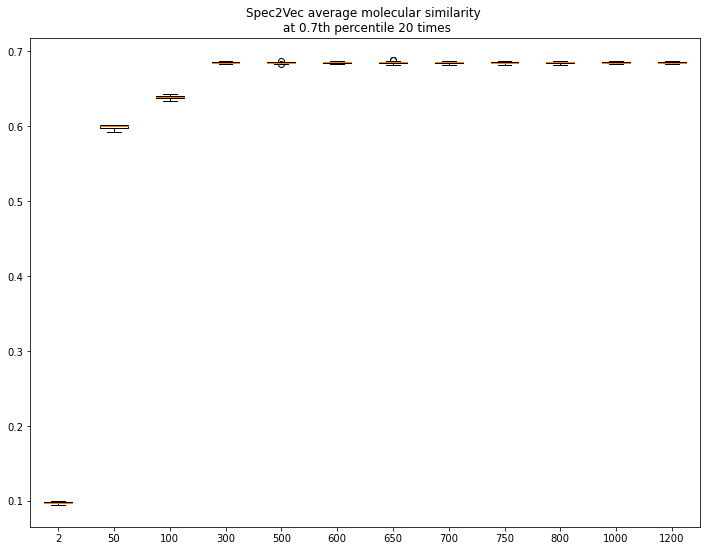

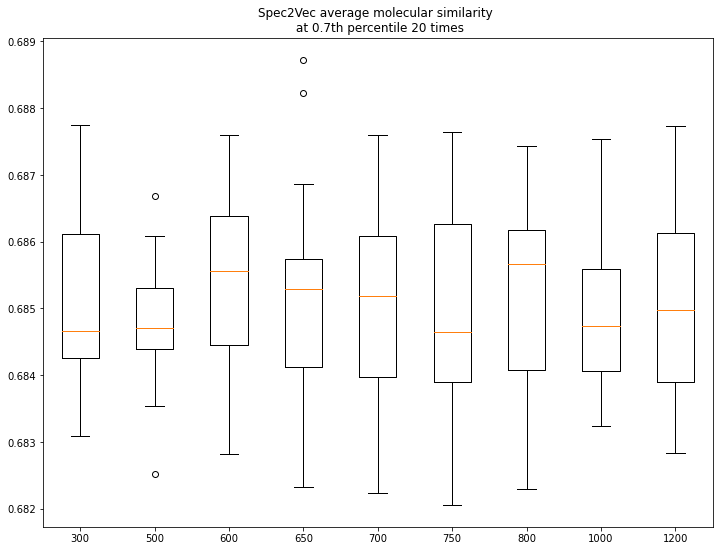

In [102]:
fig, ax = plt.subplots(figsize=(12,9))
ax.set_title('Spec2Vec average molecular similarity \n at 0.7th percentile 20 times')
ax.boxplot(iterations_list_copy)
xtickNames = plt.setp(ax, xticklabels=np.repeat(dimensions, 1))

plt.show()

fig, ax = plt.subplots(figsize=(12,9))
ax.set_title('Spec2Vec average molecular similarity \n at 0.7th percentile 20 times')
ax.boxplot(iterations_list_copy[:, 3:])
xtickNames = plt.setp(ax, xticklabels=np.repeat(dimensions[3:], 1))

plt.show()

## Plotting average molecilar similarity of 1st percentile of all space dimensions
## Plotting average molecilar similarity of 1st percentile leaving out 2, 50 and 100 dimensions

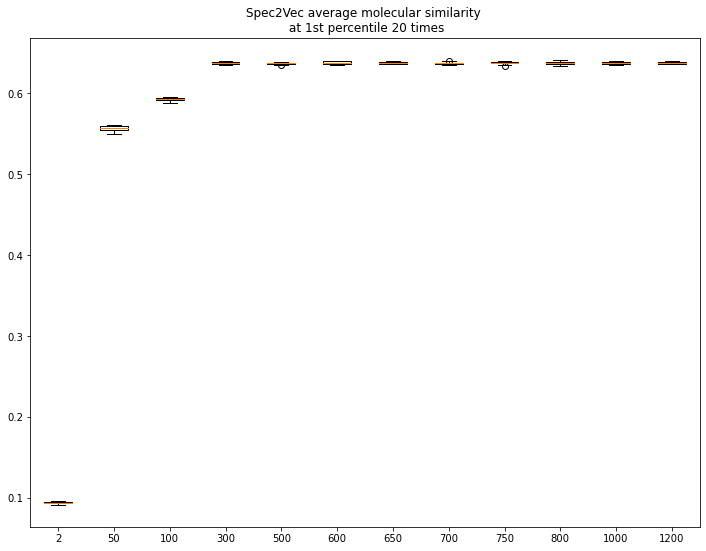

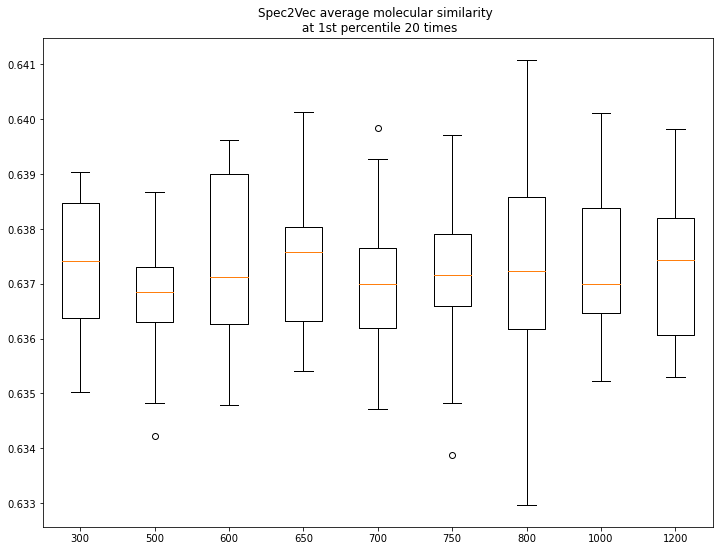

In [104]:
iterations_list_copy = np.array(iterations_list)

fig, ax = plt.subplots(figsize=(12,9))
ax.set_title('Spec2Vec average molecular similarity \n at 1st percentile 20 times')
ax.boxplot(iterations_list_copy)
xtickNames = plt.setp(ax, xticklabels=np.repeat(dimensions, 1))

plt.show()

fig, ax = plt.subplots(figsize=(12,9))
ax.set_title('Spec2Vec average molecular similarity \n at 1st percentile 20 times')
ax.boxplot(iterations_list_copy[:, 3:])
xtickNames = plt.setp(ax, xticklabels=np.repeat(dimensions[3:], 1))

plt.show()